In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
# Hyperparameters
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = 256
batch_size = 128
learning_rate = 0.001
num_epochs = 5

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize with mean and std
])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
len(train_loader), len(test_loader), len(train_dataset)

(469, 79, 60000)

In [5]:
class SparseEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)  # Activation function
        x = self.decoder(x)
        return x

    def sparsity_loss(self, hidden_representation, sparsity_target=0.1):
        # Calculate sparsity loss (L1 norm)
        return torch.mean(torch.abs(hidden_representation)) - sparsity_target

In [6]:
model = SparseEncoder(input_dim, hidden_dim).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(-1, input_dim).to('cuda')  # Reshape to (batch_size, 784)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images).to('cuda')
        sparsity = model.sparsity_loss(model.encoder(images))
        total_loss = loss + sparsity
        total_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}')


Epoch [1/5], Loss: 0.0922
Epoch [2/5], Loss: 0.0722
Epoch [3/5], Loss: 0.0572
Epoch [4/5], Loss: 0.0304
Epoch [5/5], Loss: 0.0217


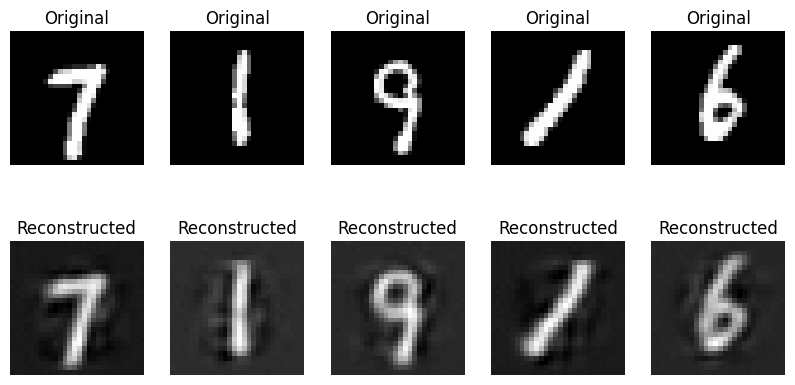

In [8]:
import matplotlib.pyplot as plt

# Function to visualize original and reconstructed images
def visualize_reconstructions(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, _ = next(iter(data_loader))
    
    with torch.no_grad():  # Disable gradient calculation
        images_flat = images.view(-1, input_dim).to('cuda')  # Flatten images
        reconstructions = model(images_flat)  # Get reconstructed images

    # Plotting
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructions[i].view(28, 28).cpu().numpy(), cmap='gray')  # Reshape for display
        plt.title('Reconstructed')
        plt.axis('off')

    plt.show()

# Visualize reconstructions
visualize_reconstructions(model, train_loader, num_images=5)


## Claude modified code

Epoch [1/5], Train Loss: 0.1283, Test Loss: 0.0552
Epoch [2/5], Train Loss: 0.0642, Test Loss: 0.0401
Epoch [3/5], Train Loss: 0.0530, Test Loss: 0.0371
Epoch [4/5], Train Loss: 0.0483, Test Loss: 0.0334
Epoch [5/5], Train Loss: 0.0475, Test Loss: 0.0330


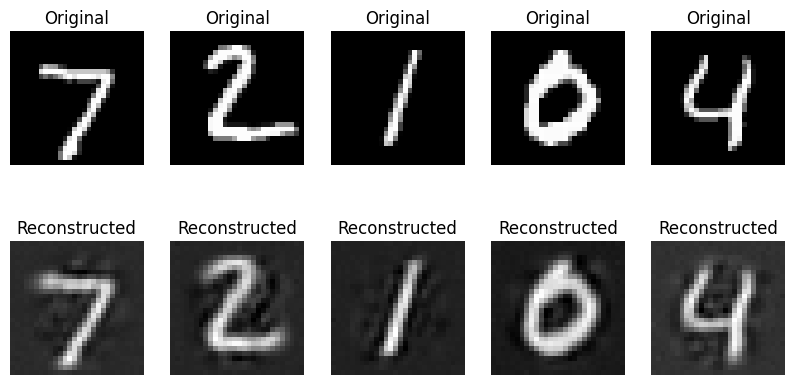

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = 28 * 28
hidden_dim = 256
batch_size = 128
learning_rate = 0.001
num_epochs = 5
sparsity_weight = 0.1

# Data loading and preprocessing with augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SparseEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        activated = torch.relu(encoded)
        decoded = self.decoder(activated)
        return decoded, activated

    def sparsity_loss(self, hidden_representation, sparsity_target=0.1):
        return torch.mean(torch.abs(hidden_representation)) - sparsity_target

model = SparseEncoder(input_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train(model, train_loader, optimizer, criterion, device, sparsity_weight):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        outputs, hidden = model(images)
        reconstruction_loss = criterion(outputs, images)
        sparsity_loss = model.sparsity_loss(hidden)
        loss = reconstruction_loss + sparsity_weight * sparsity_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, input_dim).to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(test_loader)

# Training loop
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, sparsity_weight)
    test_loss = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

def visualize_reconstructions(model, data_loader, num_images=5):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    
    with torch.no_grad():
        images_flat = images.view(-1, input_dim)
        reconstructions, _ = model(images_flat)
    
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructions[i].view(28, 28).cpu(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

visualize_reconstructions(model, test_loader, num_images=5)